In [1]:
import pandas as pd
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import io
from google.cloud import storage
import os

### Cloud client conexión

In [2]:
### entorno de google cloud con credenciales
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"C:\Users\Gastón\maestria\DM_EF\expcol-grupoB\quick-hangout-437123-m0-3f7c022fba23.json"
# Inicializo cliente
client = storage.Client()
bucket_name = "buko678"  # Modificar nombre de bucket según usuario
bucket = client.get_bucket(bucket_name)

### Función de bucket search

In [3]:
def bitacora_bucket_search(modelo, etapa):
    blob_name = f"flow227/{modelo}/bitacora_run.txt"
    blob = bucket.blob(blob_name)

    # se descarga como txt
    file_content = blob.download_as_text()
    # leo el txt a un dataframe
    df = pd.read_csv(io.StringIO(file_content), sep='\t')
    
    if etapa == 'scoring':
        ## selecciono la etapa segun el nombre de la función
        resultado = df.query('funcion == "SC_scoring_semillerio"')
        resultado = resultado.iloc[0]['expw']
        resultado = str(resultado).split('/')[-1]
        print(resultado)
        
        blob_name = f"expw227/{resultado}/tb_future_prediccion.txt"
        blob = bucket.blob(blob_name)
        # descarga el contenido del archivo como texto
        file_content_sc = blob.download_as_text()  # Si el archivo es texto

        # guardar el contenido en el diccionario
        df_resultado = pd.read_csv(io.StringIO(file_content_sc), sep='\t')
    
    elif etapa == 'kaggle':
        ## selecciono la etapa segun el nombre de la función
        resultado = df.query('funcion == "KA_evaluate_kaggle_semillerio"')
        resultado = resultado.iloc[0]['expw']
        resultado = str(resultado).split('/')[-1]
        print(resultado)
        
        
        blob_name = f"expw227/{resultado}/tb_ganancias.txt"
        blob = bucket.blob(blob_name)
        # descargar el contenido del archivo como texto
        file_content_ka = blob.download_as_text()  # Si el archivo es texto

        # guardar el contenido en el diccionario
        df_resultado = pd.read_csv(io.StringIO(file_content_ka), sep='\t')
    
    return df_resultado

### Ensamble de modelos Semillerio a Kaggle

In [44]:
modelos = [
"g01_semillerio_competencia3-005",
"g02_semillerio_competencia3-002",
"g03_semillerio_competencia3-001",
"ensamble_g01_comp3-001",
"ensamble_g02_comp3-002",
"ensamble_g03_comp3-001", 
#"ensamble_g04_comp3-004", # este es muy malo
#"ensamble_g05_comp3-002", # este tambien
"ensamble_g06_comp3-001",
#"ensamble_g07_comp3-001",
"ensamble_g08_comp3-001",
"ensamble_g09_comp3-002",
"ensamble_g10_comp3-003",
"ensamble_g11_comp3-002"]

In [45]:
predicciones = {} #demora por mi bajo computer literacy y porque los archivos son grandes? 

for modelo in modelos: 
    print(modelo)
    dataframe = bitacora_bucket_search(modelo, "scoring") # busco el archivo de scoring
    dataframe = dataframe[['numero_de_cliente', 'foto_mes', 'clase_ternaria', 'sem_1_1']] # me quedo con las columnas necesarias
    predicciones[modelo] = dataframe #guardo en el diccionario


g01_semillerio_competencia3-005
SC-0006
g02_semillerio_competencia3-002
SC-0007
g03_semillerio_competencia3-001
SC-0008
ensamble_g01_comp3-001
SC-0009
ensamble_g02_comp3-002
SC-0010
ensamble_g03_comp3-001
SC-0011
ensamble_g06_comp3-001
SC-0014
ensamble_g08_comp3-001
SC-0015
ensamble_g09_comp3-002
SC-0018
ensamble_g10_comp3-003
SC-0017
ensamble_g11_comp3-002
SC-0019


In [46]:
def merge_and_calculate_avg(predicciones):
    # listar los dataframes del dict
    dataframes = list(predicciones.values())
    
    # realizar los mergues
    merged_df = dataframes[0] # agarro el primer df
    for i, df in enumerate(dataframes[1:], start=2): #itero sobre los demas
        merged_df = merged_df.merge(df, on=['numero_de_cliente', 'foto_mes', 'clase_ternaria'], suffixes=('', f'_{i}'))
    
    # calcula el promedio de las columnas 'sem_1_1'
    sem_1_1_columns = [f'sem_1_1_{i}' if i > 1 else 'sem_1_1' for i in range(1, len(dataframes) + 1)]
    merged_df['sem_1_1_avg'] = merged_df[sem_1_1_columns].mean(axis=1)
    
    # crear el dataframe final con las columnas requeridas
    avg_df = merged_df[['numero_de_cliente', 'foto_mes', 'clase_ternaria', 'sem_1_1_avg']]
    
    return avg_df

avg_df = merge_and_calculate_avg(predicciones)
avg_df.head()

,numero_de_cliente,foto_mes,clase_ternaria,sem_1_1_avg
0,249221109,202109,NaN,0.029183
1,249221468,202109,NaN,0.036432
2,249223005,202109,NaN,0.003019
3,249232117,202109,NaN,0.019547
4,249236712,202109,NaN,0.004661


In [47]:
final_df = avg_df.sort_values("sem_1_1_avg", ascending = False).reset_index(drop = True)

ensamble_kaggle = final_df[['numero_de_cliente']].copy() # se crea el df para kaggle

# seleccion del corte
ensamble_kaggle['Predicted'] = 0
ensamble_kaggle.loc[:10999, 'Predicted'] = 1

ensamble_kaggle

,numero_de_cliente,Predicted
0,981514942,1
1,271059994,1
2,964921265,1
3,467414436,1
4,1302770401,1
...,...,...
165639,685201117,0
165640,597771053,0
165641,485683831,0
165642,350580906,0


In [48]:
cant_modelos = len(modelos)
corte = 11000

ensamble_kaggle.to_csv(f"24.12.04.kaggle_{cant_modelos}modelos_corte{corte}_vfinal.csv", index = False, sep = ',')

### Ganancias de los modelos Plot

In [49]:
ganancias = {} 

for modelo in modelos: 
    print(modelo)
    dataframe = bitacora_bucket_search(modelo, "kaggle") # busco el archivo de scoring
    #dataframe = dataframe[['numero_de_cliente', 'foto_mes', 'clase_ternaria', 'sem_1_1']] # me quedo con las columnas necesarias
    ganancias[modelo] = dataframe #guardo en el diccionario


g01_semillerio_competencia3-005
KA-0008
g02_semillerio_competencia3-002
KA-0009
g03_semillerio_competencia3-001
KA-0010
ensamble_g01_comp3-001
KA-0011
ensamble_g02_comp3-002
KA-0012
ensamble_g03_comp3-001
KA-0013
ensamble_g06_comp3-001
KA-0016
ensamble_g08_comp3-001
KA-0017
ensamble_g09_comp3-002
KA-0020
ensamble_g10_comp3-003
KA-0019
ensamble_g11_comp3-002
KA-0021


In [50]:
def merge_ganancias(ganancias):
    # obtengo los values / dataframes del dict
    dataframes = list(ganancias.values())
    
    # realizar los merges
    merged_df = dataframes[0]
    for i, df in enumerate(dataframes[1:], start=2):
        merged_df = merged_df.merge(df, on=['envios'], suffixes=('', f'_{i}'))
    
    # calcular la media de todas las columnas m1_{i}
    m1_columns = [col for col in merged_df.columns if col.startswith('m1')]
    merged_df['m1_avg'] = merged_df[m1_columns].mean(axis=1)
    
    return merged_df

merged_df = merge_ganancias(ganancias)
merged_df

,envios,rank,gan_sum,m1,rank_2,gan_sum_2,m1_2,rank_3,gan_sum_3,m1_3,...,rank_9,gan_sum_9,m1_9,rank_10,gan_sum_10,m1_10,rank_11,gan_sum_11,m1_11,m1_avg
0,10500,1,126.477,126.477,1,135.086,135.086,1,131.657,131.657,...,1,125.357,125.357,1,129.137,129.137,1,120.668,120.668,130.167636
1,11000,1,134.247,134.247,1,133.757,133.757,1,128.297,128.297,...,1,129.067,129.067,1,130.467,130.467,1,122.628,122.628,131.491545
2,11500,1,136.066,136.066,1,130.747,130.747,1,124.657,124.657,...,1,131.377,131.377,1,129.627,129.627,1,127.107,127.107,131.701273
3,12000,1,131.937,131.937,1,129.767,129.767,1,125.987,125.987,...,1,132.987,132.987,1,126.547,126.547,1,126.057,126.057,130.995182


In [51]:
merged_df[['envios', 'm1_7']]

,envios,m1_7
0,10500,135.786
1,11000,140.826
2,11500,137.326
3,12000,134.037


#### distribucion ganancias por corte

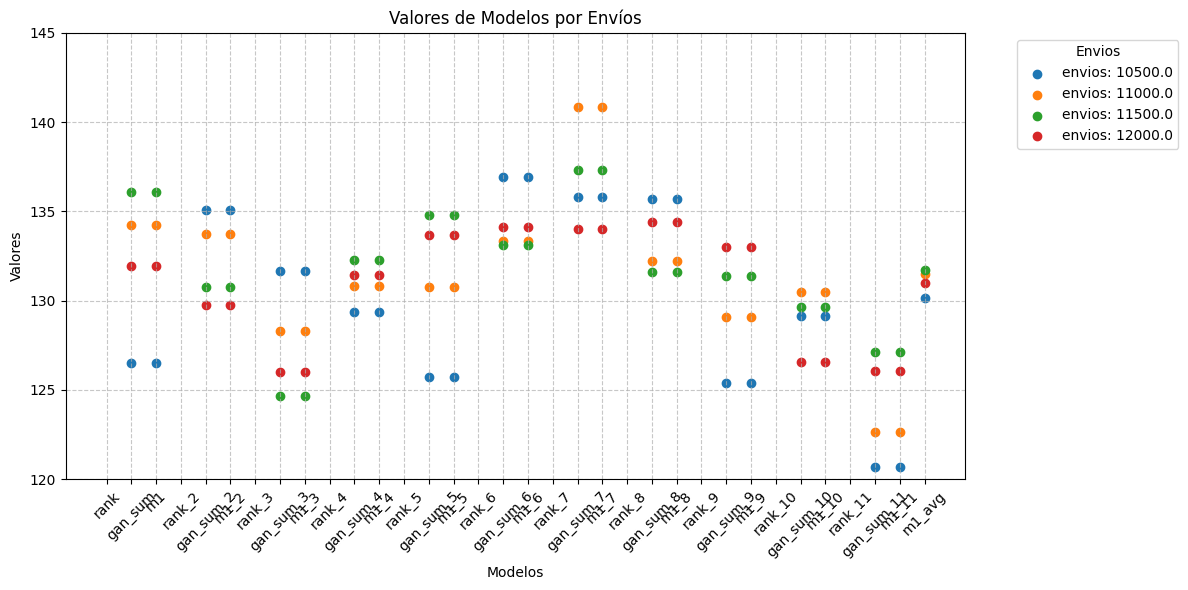

In [52]:
# Crear el gráfico
plt.figure(figsize=(12, 6))
model_columns = merged_df.columns[1:]  # Excluye la columna "envios"
for index, row in merged_df.iterrows():
    plt.scatter(model_columns, row[1:], label=f'envios: {row["envios"]}')

# Configurar el gráfico
plt.title('Valores de Modelos por Envíos')
plt.xlabel('Modelos')
plt.ylabel('Valores')
plt.ylim(120, 145)  # Ajustar la escala del eje Y
plt.xticks(rotation=45)  # Rotar las etiquetas del eje X
plt.legend(title='Envios', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

#### evolucion ganancias

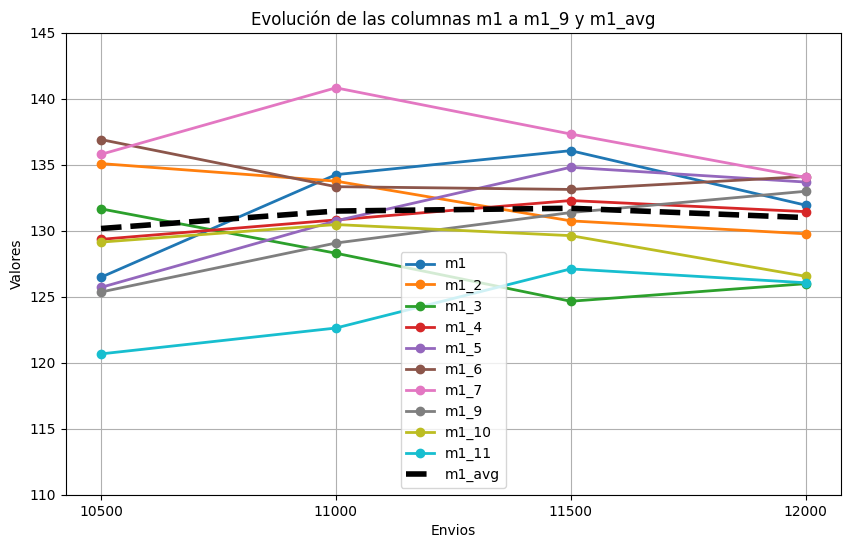

In [54]:
def plot_merged_df(merged_df):
    merged_df = merged_df.sort_values(by='envios')
    
    plt.figure(figsize=(10, 6))
    
    columns_to_plot = ['m1', 'm1_2', 'm1_3', 'm1_4', 'm1_5', 'm1_6', 'm1_7', 'm1_9', 'm1_10', 'm1_11', 'm1_avg']
    
    # Graficar cada columna
    for col in columns_to_plot:
        if col == 'm1_avg':
            plt.plot(merged_df['envios'], merged_df[col], label=col, linewidth=4, linestyle='dashed', color = 'black')
        else:
            plt.plot(merged_df['envios'], merged_df[col], label=col, linewidth=2, marker='o')
    
    # Configurar el gráfico
    plt.xlabel('Envios')
    plt.ylabel('Valores')
    plt.title('Evolución de las columnas m1 a m1_9 y m1_avg')
    plt.legend()
    plt.grid(True)
    
    # Respetar la escala exacta del eje X
    plt.xticks(merged_df['envios'])
    
    # Ajustar la escala del eje Y
    plt.ylim(110, 145)
    
    plt.show()

# Ejemplo de uso
plot_merged_df(merged_df)